In [ ]:
from IPython.display import clear_output
from google.colab import files
files.upload()
from google.colab import drive
#drive.mount('/content/drive')
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d atulanandjha/lfwpeople
!unzip lfwpeople.zip
!tar -xvzf lfw-funneled.tgz
!rm lfw-funneled.tgz lfwpeople.zip
!pip install -qq mtcnn
clear_output()

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os

import numpy as np
import pandas as pd
import pickle

import tensorflow as tf
from tensorflow.keras.applications import resnet
from tensorflow.keras.metrics import Mean, CosineSimilarity
from tensorflow.keras.layers import Layer
from tensorflow.keras.applications import resnet
from mtcnn.mtcnn import MTCNN

import matplotlib.pyplot as plt
import cv2
from PIL import Image
from glob import glob
from tqdm.notebook import trange, tqdm

from sklearn.model_selection import train_test_split

In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    #os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 42


In [ ]:
IMAGE_SIZE = 105
BATCH_SIZE = 32
epochs = 50
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
# MTCNN
face_detector = MTCNN()

def face_extraction(filename, required_size=(IMAGE_SIZE, IMAGE_SIZE)):
    image = Image.open(filename)
    image = np.array(image)

    results = face_detector.detect_faces(image)
    
    x, y, w, h = results[0]['box']
    x1, y1 = abs(x), abs(y)
    x2, y2 = x1+w, y1+h
    face_detect = image[y1:y2,x1:x2]
    face_detect = np.asarray(face_detect)
    image = cv2.resize(face_detect, required_size)
    image = Image.fromarray(image)
    clear_output()
    image.save(filename)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def crop_face(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.2, 4)
    if len(faces) > 0:
        for x, y, w, h in faces:
            image2 = image[y: y+h, x: x+w, :]
        image2 = cv2.resize(image2, (IMAGE_SIZE, IMAGE_SIZE))
        return image2, 1
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    return image, 0

In [ ]:
img_dir = glob('lfw_funneled/'+'/*/*')
img_dir = [str(x) for x in img_dir]

df = pd.DataFrame(img_dir, columns=['Image_dir'])
df['Name'] = df['Image_dir'].str.split('/', expand=True).loc[:, [1,]]
df["count"] = df.groupby("Name")["Image_dir"].transform("count")

In [ ]:
for i in trange(len(df)):
    image = Image.open(df.iloc[i,0])
    image = np.array(image)
    image, _ = crop_face(image)
    image = Image.fromarray(image)
    image.save(df.iloc[i,0])

  0%|          | 0/13233 [00:00<?, ?it/s]

In [ ]:
def preprocess_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    return image

def preprocess_triplets(anchor, positive, negative):
    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [ ]:
from itertools import combinations

def get_images(data):
    samples = {"positives": [], "anchors": [], "negatives": []}
    most = data[data["count"] > 4]
    for name in tqdm(most["Name"].unique()):
        pos_dirs = most.loc[most["Name"] == name, "Image_dir"].sample(5).values.tolist()
        for pos, anc in combinations(pos_dirs, r=2):
            if pos == anc:
                continue
            samples["positives"].append(pos)
            samples["anchors"].append(anc)
        neg_dirs = data.loc[~data["Image_dir"].isin(pos_dirs), "Image_dir"].sample(len(samples["positives"])-len(samples["negatives"])).values.tolist()
        samples["negatives"].extend(neg_dirs)
    return samples

In [ ]:
samples = get_images(df)

  0%|          | 0/423 [00:00<?, ?it/s]

In [ ]:
len(samples["positives"]), len(samples["negatives"]), len(samples["anchors"])

(4230, 4230, 4230)

In [ ]:
def visualize(anchor, positive, negative, n=3, is_read=True):
    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 3*n))

    axs = fig.subplots(n, 3)
    for i in range(n):
        if is_read:
            im1 = Image.open(anchor[i])
            im2 = Image.open(positive[i])
            im3 = Image.open(negative[i])
            show(axs[i, 0], im1)
            show(axs[i, 1], im2)
            show(axs[i, 2], im3)
        else:
            show(axs[i, 0], anchor[i])
            show(axs[i, 1], positive[i])
            show(axs[i, 2], negative[i])
    plt.tight_layout()

In [ ]:
visualize(samples["positives"][-10:], samples["negatives"][-10:], samples["anchors"][-10:], n=10)

In [ ]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(samples["anchors"])
positive_dataset = tf.data.Dataset.from_tensor_slices(samples["positives"])
negative_dataset = tf.data.Dataset.from_tensor_slices(samples["negatives"])

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

train_dataset = dataset.take(round(4230 * 0.8))
valid_dataset = dataset.skip(round(4230 * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(AUTOTUNE)

valid_dataset = valid_dataset.batch(32, drop_remainder=False)
valid_dataset = valid_dataset.prefetch(AUTOTUNE)

In [ ]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False
)

flatten = tf.keras.layers.Flatten()(base_cnn.output)
dense1 = tf.keras.layers.Dense(512, activation="relu")(flatten)
dense1 = tf.keras.layers.BatchNormalization()(dense1)
dense2 = tf.keras.layers.Dense(256, activation="relu")(dense1)
dense2 = tf.keras.layers.BatchNormalization()(dense2)
output = tf.keras.layers.Dense(128)(dense2)

embedding = tf.keras.Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":  # for resnet
        trainable = True
    layer.trainable = trainable

In [ ]:
class DistanceLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return ap_distance, an_distance


anchor_input = tf.keras.layers.Input(name="anchor", shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
positive_input = tf.keras.layers.Input(name="positive", shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
negative_input = tf.keras.layers.Input(name="negative", shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = tf.keras.Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [ ]:
class SiameseModel(tf.keras.Model):
    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]

In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(0.00001), weighted_metrics=[])

callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(patience=3),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
            ]

In [ ]:
siamese_model.fit(train_dataset, epochs=100, validation_data=valid_dataset, callbacks=callbacks)

Epoch 1/100
106/106 [==============================] - 32s 216ms/step - loss: 0.4401 - val_loss: 0.3947 - lr: 1.0000e-05
Epoch 2/100
106/106 [==============================] - 20s 189ms/step - loss: 0.3825 - val_loss: 0.3455 - lr: 1.0000e-05
Epoch 3/100
106/106 [==============================] - 19s 184ms/step - loss: 0.3461 - val_loss: 0.3143 - lr: 1.0000e-05
Epoch 4/100
106/106 [==============================] - 20s 185ms/step - loss: 0.3180 - val_loss: 0.2966 - lr: 1.0000e-05
Epoch 5/100
106/106 [==============================] - 20s 185ms/step - loss: 0.2947 - val_loss: 0.2871 - lr: 1.0000e-05
Epoch 6/100
106/106 [==============================] - 20s 186ms/step - loss: 0.2717 - val_loss: 0.2597 - lr: 1.0000e-05
Epoch 7/100
106/106 [==============================] - 20s 185ms/step - loss: 0.2582 - val_loss: 0.2492 - lr: 1.0000e-05
Epoch 8/100
106/106 [==============================] - 20s 185ms/step - loss: 0.2520 - val_loss: 0.2373 - lr: 1.0000e-05
Epoch 9/100
106/106 [===========

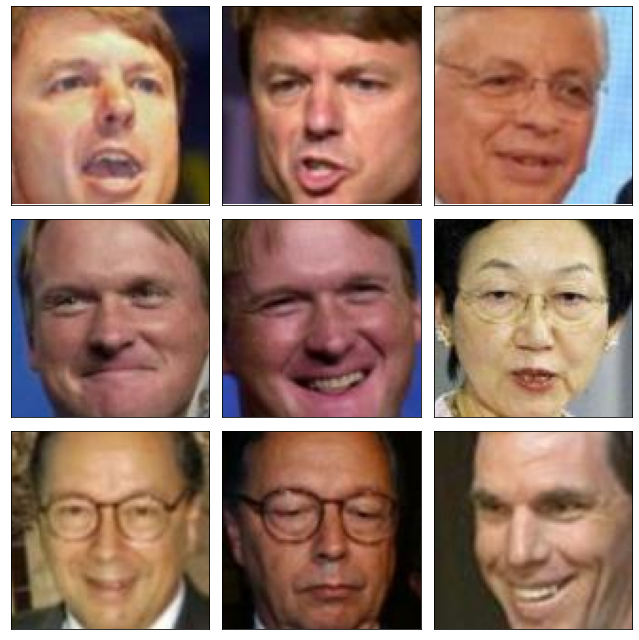

In [ ]:
sample = next(iter(valid_dataset))
anchor, positive, negative = sample
anchor, positive, negative = anchor.numpy(), positive.numpy(), negative.numpy()
visualize(anchor, positive, negative, is_read=False)

In [ ]:
sample = next(iter(valid_dataset))
anchor, positive, negative = sample

anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

In [ ]:
cosine_similarity = tf.keras.metrics.CosineSimilarity()

acc = 0
for ix in range(32):
    positive_similarity = cosine_similarity(anchor_embedding[ix], positive_embedding[ix])
    negative_similarity = cosine_similarity(anchor_embedding[ix], negative_embedding[ix])
    if positive_similarity.numpy().item() > negative_similarity.numpy().item():
        acc += 1
print(f"Accuracy: {acc / 32:.4f}")

Accuracy: 0.7188
